In [ ]:
pip install opendatasets

# Natural Language Processing with Disaster Tweets
## Using LSTM, a RNN, Approach

In [103]:
#importing the necessary libraries
import opendatasets as od #to import Kaggle dataset, also need Kaggle API

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Input, Embedding
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## 1 Brief description of the problem and data

In this Kaggle project, "Natural Language Processing with Disaster Tweets," we are tasked with designing a model which will predict which tweets are about a real disaster and which are not. If a tweet in the training set is regarding a real disaster then it is labeled a 1 in the target column and a 0 otherwise. The goal is to create a model which accurately predicts if a tweet is regarding a real disaster or not. The competition and datasets are available on Kaggle at https://www.kaggle.com/competitions/nlp-getting-started/overview .$^{1}$

We will begin by importing the datasets from Kaggle. If you plan to run this code lcoally without changing the code to access to the data files, you will need your login info and API from Kaggle.

In [ ]:
#importing all of the datasets straight from Kaggle
od.download("https://www.kaggle.com/competitions/nlp-getting-started/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heathermelrose
Your Kaggle Key: ··········


100%|██████████| 593k/593k [00:00<00:00, 88.0MB/s]


Extracting archive ./nlp-getting-started/nlp-getting-started.zip to ./nlp-getting-started


In [ ]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')

## 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Let's take a minute to look at the data,

In [ ]:
print('Head of Training Set Data File:')
print(train_df.head())
print('')
print('Training Set Data Null Values:')
print(train_df.isna().sum())
print('')
print('Training Set Data Unique Values:')
print(train_df.nunique())
print('')
print('Variable Sizes and Datatypes')
print('')
train_df.info()

Head of Training Set Data File:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Training Set Data Null Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Training Set Data Unique Values:
id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

Variable Sizes and Datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dty

We have several variables here.

*   id - unique identifier for each tweet
*   keyword - a particular word from the tweet with 61 null entries
*   location - where the tweet was sent from, 2533 are null
*   text - the words in the tweet
*   target - the classifier, 1 = disaster, 0 = not a disaster

There are 7613 entries in this dataframe without any null values for text, id or target.

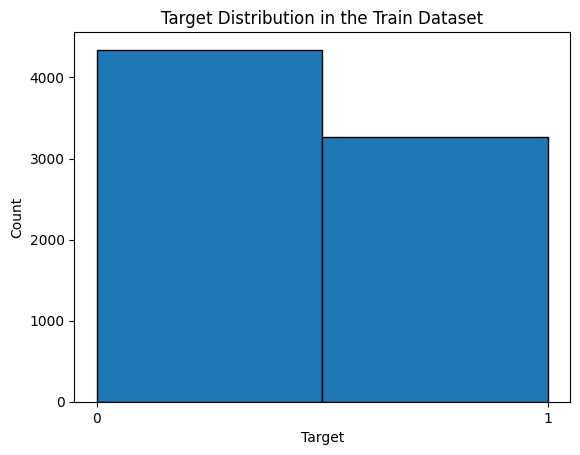

In [ ]:
counts, bins = np.histogram(train_df['target'])
plt.hist(train_df['target'], bins =2, edgecolor='black')
plt.xticks(ticks = [0,1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution in the Train Dataset')
plt.show()

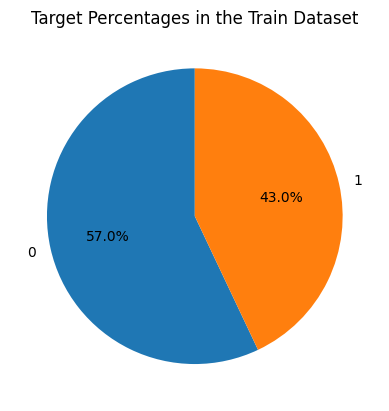

In [ ]:
train_category = train_df.groupby(by='target').size()
plt.pie(train_category, labels=train_category.index, autopct='%1.1f%%', startangle=90)
plt.title('Target Percentages in the Train Dataset')
plt.show()

57% of the tweets, or 4340, are not related to real disasters, leaving 43% that are real disasters.

It would take us quite some time to read over 3000 tweets to understand what the real disaster texts look like. Instead, let's look at the keywords. What exactly are the 221 unique keywords? Let's take a look, keeping in mind that "%20" represents a space between two words,

In [ ]:
train_df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

For a project about disasters, these keywrods are not too surprising. There are a few which could confuse a NLP model, espeically when we consider slang. For example, "I'm dead" can mean that the author finds something hilariously funny but the word dead included in the keyword list uses an entirely different definition.

Looking at these keywords, location without the inclusion of dates is unlikely to help us assess whether or not the text is referring to a real disater. For example let's look at the keyword 'lava'. If lava was tweeted in May of 2018 from the Big Island of Island, we could use location and date together to determine that the tweet is referencing a real disaster. That is not possible with this dataset which lacks dates. Additionally, it is not in the spirit of the project, we are tasked with using langauge to determine whether or not a real disaster is being referenced. Hence, we will not be utilizing location in our model.

Keyword and Text, are linearly dependent. Keyword for each entry comes directly from Text. Since we are attempting to label tweets using a RNN, we are going to use Text as our input variable. Keyword becomes redundant and will be excluded.

Id is merely a unique identifer, and thus can be left out of the model.

Before we begin building a model, a little data cleaning needs to take place on the tweets (text) themselves. Let's remove punctuation, emojis, URLs and HTML tags$^{2}$:

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train_df['text']=train_df['text'].apply(lambda x:remove_html(x))

In [ ]:
def remove_url(text):
    url=re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
train_df['text']=train_df['text'].apply(lambda x:remove_url(x))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile('['
                                u"\U0001F600-\U0001F64F"
                                u"\U0001F300-\U0001F5FF"
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F1E0-\U0001F1FF"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                ']+',flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)
train_df['text']=train_df['text'].apply(lambda x:remove_emoji(x))

In [ ]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)
train_df['text']=train_df['text'].apply(lambda x: remove_punct(x))

## 3 Model Architecture

In class this week we learned about Long Short Term Memory (LSTM), a special case of a Recurrent Neural Network (RNN). RNNs are especially good for sequences and lists, such as speech recognition and language modeling. In addition, LSTMs are capable of learning long term dependencies.  Thus this model is going to use the keras library with a LSTM layer. LSTM, hopefully, will help discern the slang from the real disasters.

Let's reshape our training set, and split the data into training and validation parts. Keeping with the keras library, we are going to use their preprocessing Tokenizer method to change the plain, cleaned text into a sequence.$^{3}$ In addition to keras's Tokenizer, we are going to add padding to ensure that all of the sequences are of the same length. Then, we will build our LSTM model using one layer of LSTM with 64 units and a dropout layer. We will compile the model using Adam optimizer, binary crossentropy loss and accuracy as our metric, since F1 is the grading statistic used by Kaggle.  

In [ ]:
X = train_df.text
Y = train_df.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN_1():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN_1()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

## 4 Results and Analysis

Let's fit the model utilizing keras's EarlyStopping method to keep epochs to a practical number.

In [ ]:
hist1 = model.fit(sequences_matrix,y_train,batch_size=256,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
20/20 [==============================] - 11s 427ms/step - loss: 0.6841 - accuracy: 0.5638 - val_loss: 0.6719 - val_accuracy: 0.5698
Epoch 2/10
20/20 [==============================] - 7s 357ms/step - loss: 0.6402 - accuracy: 0.6242 - val_loss: 0.5835 - val_accuracy: 0.7438
Epoch 3/10
20/20 [==============================] - 8s 382ms/step - loss: 0.4982 - accuracy: 0.7818 - val_loss: 0.4835 - val_accuracy: 0.7685
Epoch 4/10
20/20 [==============================] - 8s 415ms/step - loss: 0.4112 - accuracy: 0.8190 - val_loss: 0.4613 - val_accuracy: 0.7726
Epoch 5/10
20/20 [==============================] - 7s 354ms/step - loss: 0.3879 - accuracy: 0.8346 - val_loss: 0.4472 - val_accuracy: 0.7997
Epoch 6/10
20/20 [==============================] - 8s 398ms/step - loss: 0.3681 - accuracy: 0.8428 - val_loss: 0.4525 - val_accuracy: 0.7989


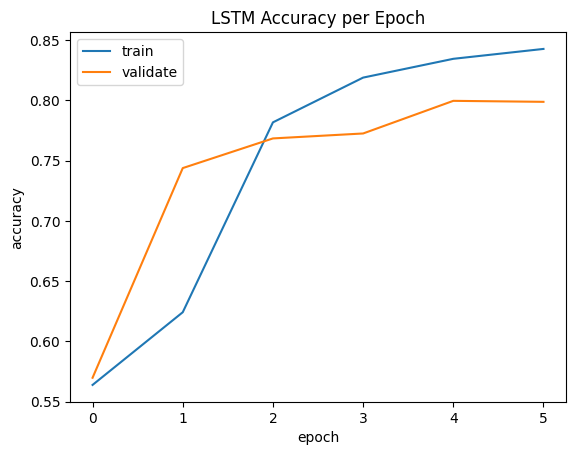

In [ ]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('LSTM Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

The accuracy of this model is pretty good. Over 5 epochs, the training set climbs to 84% accuracy and appears to being leveling off as the EarlyStopping threshold is reached. The validation set follows a similar curve, but clearly levels off an epoch sooner at only 80%.

Let's see if we can do better by changing the hyperparameter of 64 LSTM units to 128 units, doubling their number, while keeping all other parameters the same,

In [ ]:
def RNN_2():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model_2 = RNN_2()
model_2.summary()
model_2.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
hist2 = model_2.fit(sequences_matrix,y_train,batch_size=256,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
20/20 [==============================] - 23s 1s/step - loss: 0.6759 - accuracy: 0.5757 - val_loss: 0.6542 - val_accuracy: 0.6092
Epoch 2/10
20/20 [==============================] - 14s 724ms/step - loss: 0.5968 - accuracy: 0.7157 - val_loss: 0.6095 - val_accuracy: 0.7422
Epoch 3/10
20/20 [==============================] - 14s 726ms/step - loss: 0.4593 - accuracy: 0.7917 - val_loss: 0.4580 - val_accuracy: 0.8005
Epoch 4/10
20/20 [==============================] - 14s 725ms/step - loss: 0.4034 - accuracy: 0.8255 - val_loss: 0.4480 - val_accuracy: 0.7931
Epoch 5/10
20/20 [==============================] - 14s 726ms/step - loss: 0.3749 - accuracy: 0.8422 - val_loss: 0.4612 - val_accuracy: 0.7964


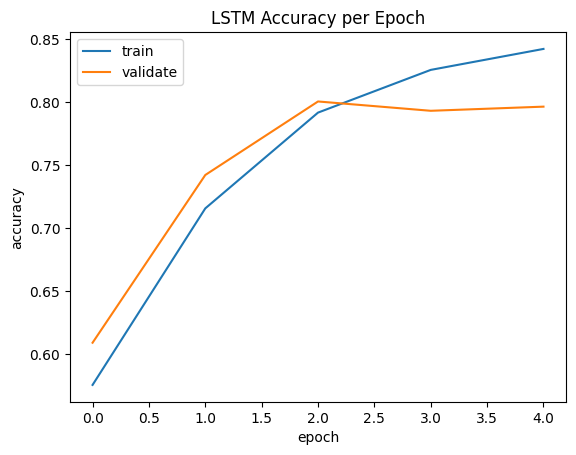

In [ ]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('LSTM Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

Doubling the LSTM units doubled the run time which is expected; however, with a runtime per epoch ranging between 14 and 23 seconds, this is still a reasonable model.

By doubling the number of LSTM units, we reached the same EarlyStopping threshold one epoch sooner, but the resulting accuracy is the same. Let's look at the two hyperparameters side by side,

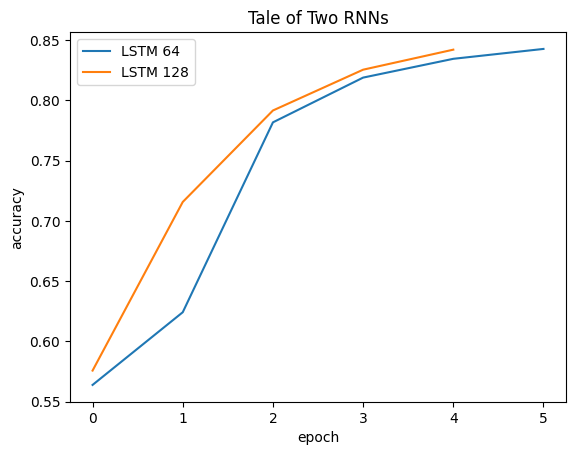

In [ ]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.title('Tale of Two RNNs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM 64', 'LSTM 128'], loc='upper left')
plt.show();

The accuracy is pretty much the same whether we use 64 or 128 LSTM units. Increasing the number of LSTM units improves how quickly the LSTM model reaches 84% accuracy. Since we get to the same level of accuracy one epoch sooner with marginal increase in runtime per layer, let's keep the number of LSTM units at 128 and try removing the dropout layer to see if that improves accuracy.

In [ ]:
def RNN_3():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model_3 = RNN_3()
model_3.summary()
model_3.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_7 (Activation)   (None, 1)                 0   

In [ ]:
hist3 = model_3.fit(sequences_matrix,y_train,batch_size=256,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
20/20 [==============================] - 14s 719ms/step - loss: 0.6692 - accuracy: 0.5807 - val_loss: 0.6239 - val_accuracy: 0.6831
Epoch 2/10
20/20 [==============================] - 14s 724ms/step - loss: 0.5367 - accuracy: 0.7504 - val_loss: 0.4796 - val_accuracy: 0.7718
Epoch 3/10
20/20 [==============================] - 15s 737ms/step - loss: 0.4246 - accuracy: 0.8050 - val_loss: 0.4576 - val_accuracy: 0.7956
Epoch 4/10
20/20 [==============================] - 14s 719ms/step - loss: 0.3800 - accuracy: 0.8344 - val_loss: 0.4519 - val_accuracy: 0.7915
Epoch 5/10
20/20 [==============================] - 15s 739ms/step - loss: 0.3571 - accuracy: 0.8539 - val_loss: 0.4848 - val_accuracy: 0.7915


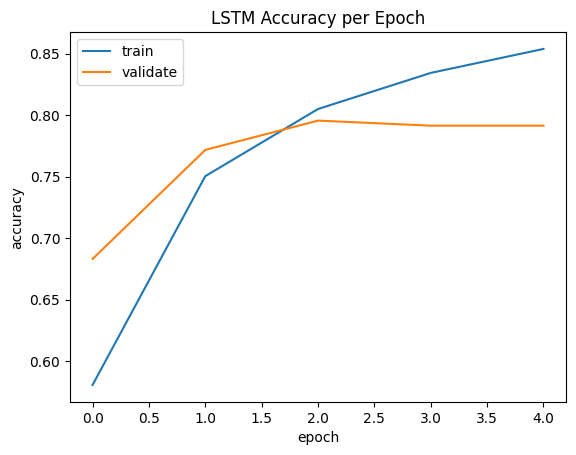

In [ ]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('LSTM Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

We had a very small (1%) increase in accuracy by removing the dropout layer and a faster first epoch run time.

Let's compare the two 128 unit models,

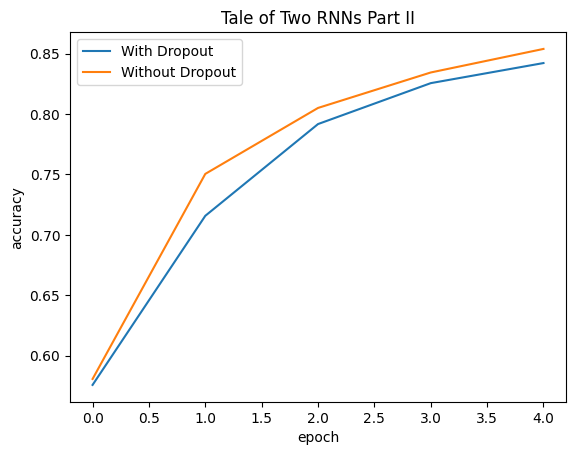

In [ ]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist3.history['accuracy'])
plt.title('Tale of Two RNNs Part II')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['With Dropout', 'Without Dropout'], loc='upper left')
plt.show();

The above graph compares the two 128 unit LSTM models, one with dropout and the other without. The LSTM model without dropout has a slightly better accuracy curve and is the winner albeit by the slightest of margins on the training data. To summarize the final values of each hyperparameter please see the table below,

In [108]:
print(tabulate([['LSTM with 64 units', hist1.history['accuracy'][5], hist1.history['loss'][5],hist1.history['val_accuracy'][5],hist1.history['val_loss'][5]],
                ['LSTM with 128 units', hist2.history['accuracy'][4], hist2.history['loss'][4],hist2.history['val_accuracy'][4],hist2.history['val_loss'][4]],
                ['LSTM without Dropout', hist3.history['accuracy'][4], hist3.history['loss'][4],hist3.history['val_accuracy'][4],hist3.history['val_loss'][4]]],
               headers=['Models', 'Training Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']))

Models                  Training Accuracy    Train Loss    Validation Accuracy    Validation Loss
--------------------  -------------------  ------------  ---------------------  -----------------
LSTM with 64 units               0.842775      0.368098               0.798851           0.45254
LSTM with 128 units              0.842159      0.374924               0.796387           0.461193
LSTM without Dropout             0.853859      0.357115               0.791461           0.484805


## 5 Conclusion

The decision to use LSTM was based on what we learned in class this week and the nature of the dataset, a language modeling project. Playing with the hyperparameters, we learned that increasing the number of LSTM units led to decreasing the number of epochs needed. Accuracy improved only slightly by adding LSTM units and removing dropout.

Future work might include increasing the LSTM units even more, changing the optimization from Adam to SGD or RMSProp, and removing the EarlyStopping threshold. In addition to changing the LSTM model during future work, I would try text processing techniques which differ from the Tokenizer method used here; future options include GloVe and Word2Vec.

## 6 Creating a Kaggle Submission csv

Clean the test set,

In [ ]:
test_df['text']=test_df['text'].apply(lambda x:remove_html(x))
test_df['text']=test_df['text'].apply(lambda x:remove_url(x))
test_df['text']=test_df['text'].apply(lambda x:remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_punct(x))


In [ ]:
sub = test_df['text']

Tokenize the data to turn the text into sequences, then pad to be the same length,

In [ ]:
tok2 = Tokenizer(num_words=max_words)
tok2.fit_on_texts(sub)
sequences2 = tok2.texts_to_sequences(sub)
sequences_matrix2 = sequence.pad_sequences(sequences2,maxlen=max_len)

Get an idea of what the submission file should look like,

In [ ]:
sample_submission = pd.read_csv("nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Build the prediction on the test set and create the submission file.

In [ ]:
pred = model_3.predict(sequences_matrix2)

102/102 [==============================] - 8s 78ms/step


In [ ]:
predictions = np.transpose(pred)[0]
copy_df = pd.DataFrame()
copy_df['id'] = sample_submission['id'] #.apply(lambda x: x.split('.')[0])
copy_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
copy_df['target'].value_counts()
copy_df.to_csv('submission.csv', index=False)

## 7 Works Cited

$^{1}$ "Natural Language Processing with Disaster Tweets." Kaggle. https://www.kaggle.com/competitions/nlp-getting-started/overview

$^{2}$ Abhishek, Mehra. "RandomForestClassifier,CountVectorizer." Kaggle. https://www.kaggle.com/code/abhismehra/randomforestclassifier-countvectorizer

$^{3}$ "Tokenizer base class." KerasNLP. https://keras.io/api/keras_nlp/tokenizers/tokenizer/

## 8 Link for GitHub Repository

https://github.com/minesalum/msds5511-LSTM.git